# Filter out low mean abundance features in the heatmaps and sort them by how prevalent they are in each category

In [1]:
%matplotlib inline

import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt

from qiime.parse import parse_mapping_file
from qiime.format import format_mapping_file
from skbio.io.util import open_file
from scipy.stats import pearsonr, spearmanr
from biom import load_table

from IPython.display import Image

def load_mf(fn):
    with open_file(fn, 'U') as f:
        mapping_data, header, _ = parse_mapping_file(f)
        _mapping_file = pd.DataFrame(mapping_data, columns=header)
        _mapping_file.set_index('SampleID', inplace=True)
    return _mapping_file

def write_mf(f, _df):
    with open_file(f, 'w') as fp:
        lines = format_mapping_file(['SampleID'] + _df.columns.tolist(),
                                    list(_df.itertuples()))
        fp.write(lines+'\n')

In [2]:
def exploding_panda(_bt):
    """BIOM->Pandas dataframe converter

    Parameters
    ----------
    _bt : biom.Table
        BIOM table

    Returns
    -------
    pandas.DataFrame
        The BIOM table converted into a DataFrame
        object.
        
    References
    ----------
    Based on this answer on SO:
    http://stackoverflow.com/a/17819427/379593
    """
    m = _bt.matrix_data
    data = [pd.SparseSeries(m[i].toarray().ravel()) for i in np.arange(m.shape[0])]
    out = pd.SparseDataFrame(data, index=_bt.ids('observation'),
                             columns=_bt.ids('sample'))
    
    return out.to_dense()

We filter out OTUs that are not present in at least 10 percent of the samples and in at least 20 percent of the sample. This helps us reduce the penalization that we get from doing multiple comparisons and to only assess the statistical significance of microbes that are well represented by the samples (HT to Kyle Bittinger, as I discussed a lot about this with him at the Quebec QIIME workshop).

In [37]:
%%bash

mkdir -p stats/group-significance/no-diarrhea/

# 5 percent
filter_otus_from_otu_table.py -s 8 \
-i otu_table.15000.no-diarrhea.biom \
-o stats/group-significance/no-diarrhea/otu_table.15000.no-diarrhea.5pct.biom

# 10 percent
filter_otus_from_otu_table.py -s 16 \
-i otu_table.15000.no-diarrhea.biom \
-o stats/group-significance/no-diarrhea/otu_table.15000.no-diarrhea.10pct.biom

# 20 percent
filter_otus_from_otu_table.py -s 32 \
-i otu_table.15000.no-diarrhea.biom \
-o stats/group-significance/no-diarrhea/otu_table.15000.no-diarrhea.20pct.biom

# 40 percent
filter_otus_from_otu_table.py -s 64 \
-i otu_table.15000.no-diarrhea.biom \
-o stats/group-significance/no-diarrhea/otu_table.15000.no-diarrhea.40pct.biom

In [41]:
%%bash -e

# 5 percent
summarize_taxa.py \
-i stats/group-significance/no-diarrhea/otu_table.15000.no-diarrhea.5pct.biom \
-o stats/group-significance/no-diarrhea/taxa-summaries-5pct/

# genus
group_significance.py \
-i stats/group-significance/no-diarrhea/taxa-summaries-5pct/otu_table.15000.no-diarrhea.5pct_L6.biom \
-m mapping-file-full.alpha.L6index.txt \
-c disease_stat \
-o stats/group-significance/no-diarrhea/kruskall-wallis-5pct-L6.tsv \
-s kruskal_wallis

# family
group_significance.py \
-i stats/group-significance/no-diarrhea/taxa-summaries-5pct/otu_table.15000.no-diarrhea.5pct_L5.biom \
-m mapping-file-full.alpha.L6index.txt \
-c disease_stat \
-o stats/group-significance/no-diarrhea/kruskall-wallis-5pct-L5.tsv \
-s kruskal_wallis

# order
group_significance.py \
-i stats/group-significance/no-diarrhea/taxa-summaries-5pct/otu_table.15000.no-diarrhea.5pct_L4.biom \
-m mapping-file-full.alpha.L6index.txt \
-c disease_stat \
-o stats/group-significance/no-diarrhea/kruskall-wallis-5pct-L4.tsv \
-s kruskal_wallis

# class
group_significance.py \
-i stats/group-significance/no-diarrhea/taxa-summaries-5pct/otu_table.15000.no-diarrhea.5pct_L3.biom \
-m mapping-file-full.alpha.L6index.txt \
-c disease_stat \
-o stats/group-significance/no-diarrhea/kruskall-wallis-5pct-L3.tsv \
-s kruskal_wallis

# 10 percent
summarize_taxa.py \
-i stats/group-significance/no-diarrhea/otu_table.15000.no-diarrhea.10pct.biom \
-o stats/group-significance/no-diarrhea/taxa-summaries-10pct/

group_significance.py \
-i stats/group-significance/no-diarrhea/taxa-summaries-10pct/otu_table.15000.no-diarrhea.10pct_L6.biom \
-m mapping-file-full.alpha.L6index.txt \
-c disease_stat \
-o stats/group-significance/no-diarrhea/kruskall-wallis-10pct-L6.tsv \
-s kruskal_wallis

# 40 percent
summarize_taxa.py \
-i stats/group-significance/no-diarrhea/otu_table.15000.no-diarrhea.40pct.biom \
-o stats/group-significance/no-diarrhea/taxa-summaries-40pct/

group_significance.py \
-i stats/group-significance/no-diarrhea/taxa-summaries-40pct/otu_table.15000.no-diarrhea.40pct_L6.biom \
-m mapping-file-full.alpha.L6index.txt \
-c disease_stat \
-o stats/group-significance/no-diarrhea/kruskall-wallis-40pct-L6.tsv \
-s kruskal_wallis

group_significance.py \
-i stats/group-significance/no-diarrhea/taxa-summaries-40pct/otu_table.15000.no-diarrhea.40pct_L4.biom \
-m mapping-file-full.alpha.L6index.txt \
-c disease_stat \
-o stats/group-significance/no-diarrhea/kruskall-wallis-40pct-L4.tsv \
-s kruskal_wallis

/Users/yoshikivazquezbaeza/.virtualenvs/qiime-191/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


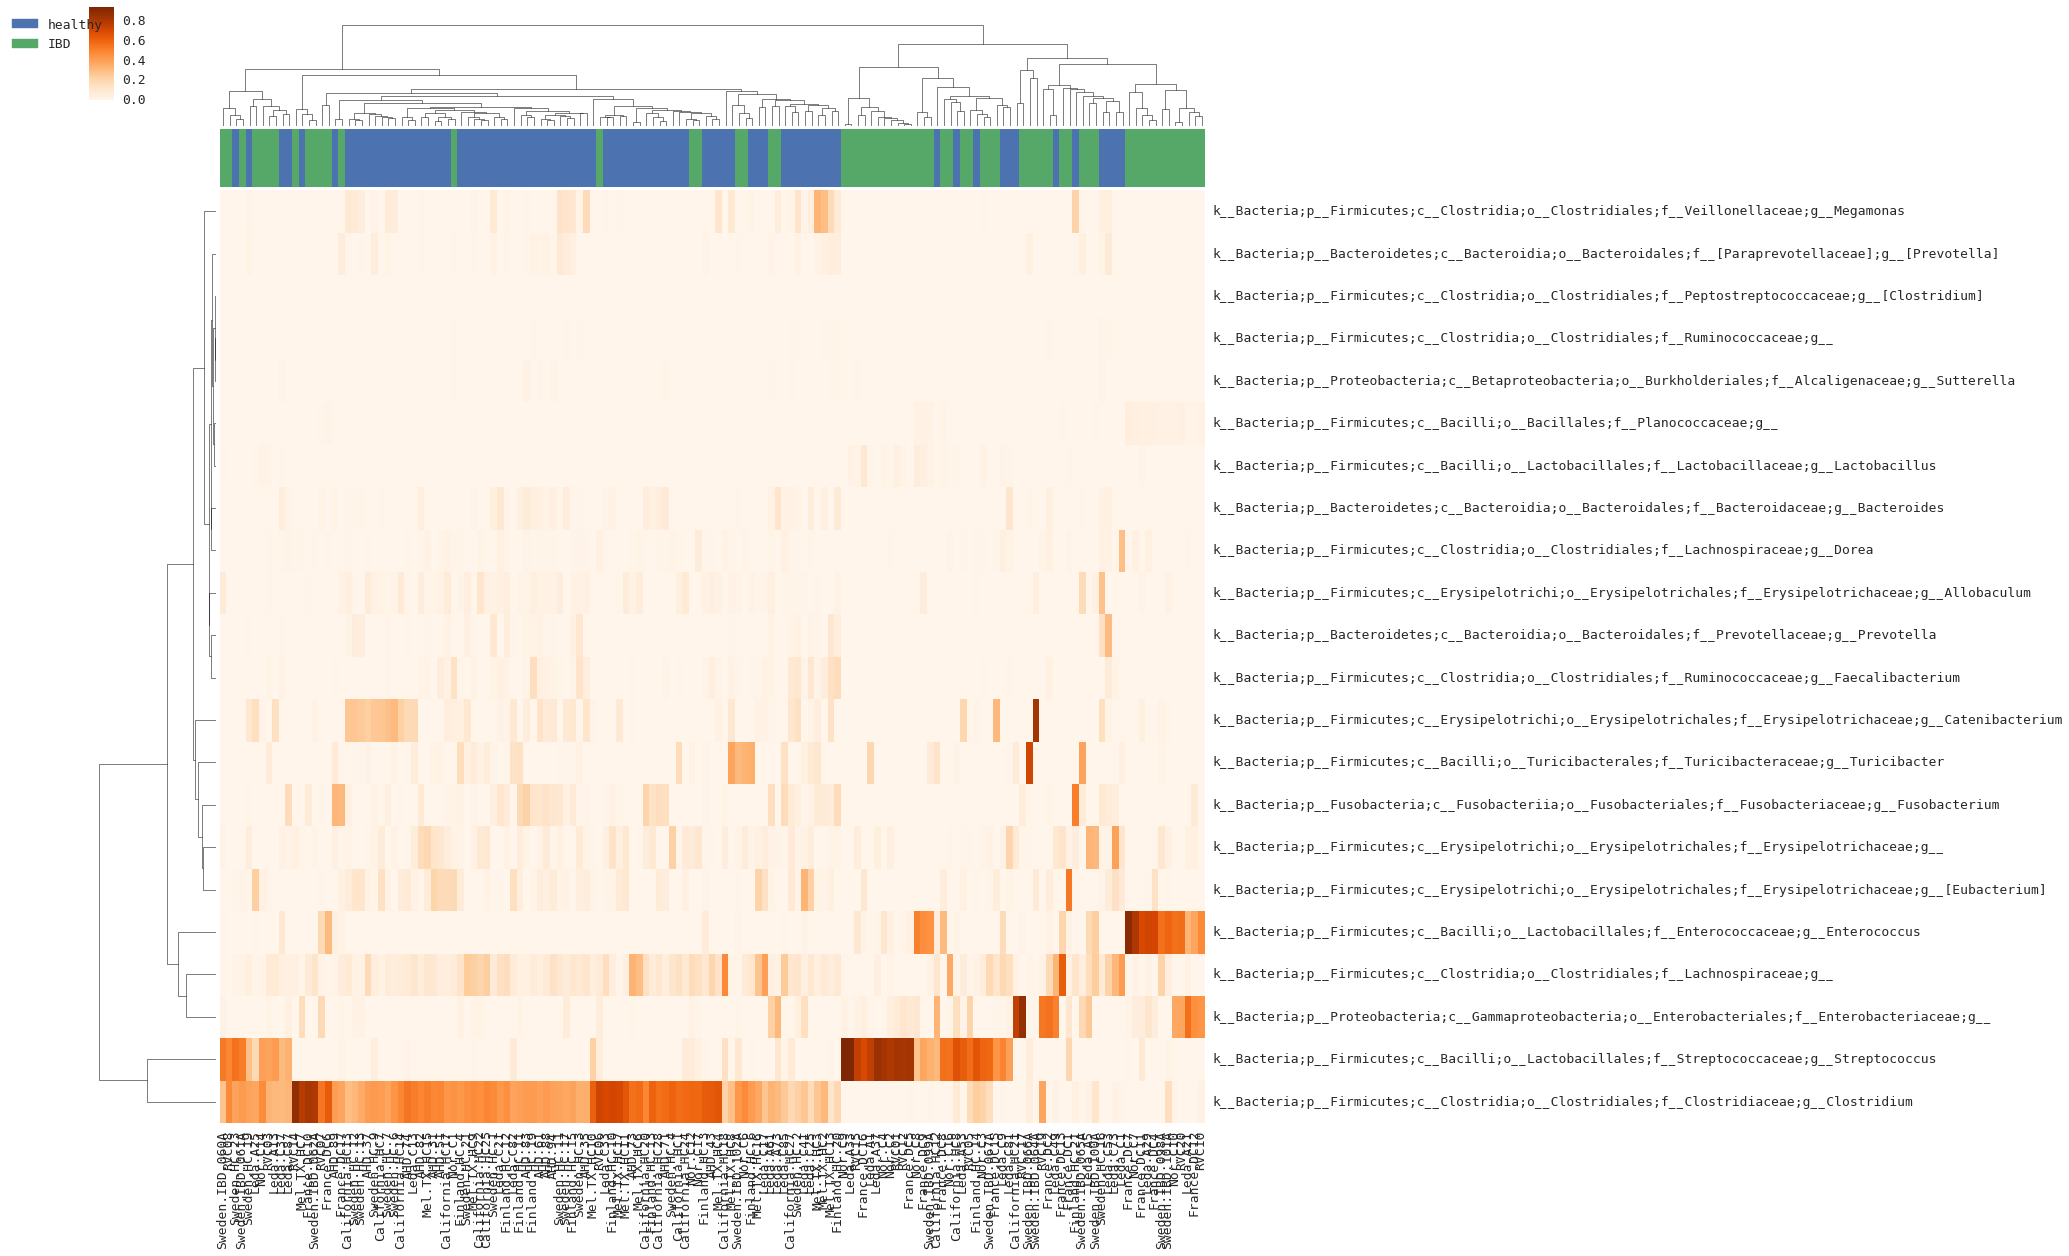

In [3]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

sns.set(font="monospace")
sns.set_context("talk")

bt = load_table('stats/group-significance/no-diarrhea/taxa-summaries-40pct/otu_table.15000.no-diarrhea.40pct_L6.biom')
mf = load_mf('mapping-file-full.alpha.L6index.txt')
mf = mf.loc[bt.ids('sample')]

# dataframe from the group significance table
gsdf = pd.read_csv('stats/group-significance/no-diarrhea/kruskall-wallis-40pct-L6.tsv',
                   sep='\t')
gsdf = gsdf[gsdf['Bonferroni_P'] < 0.05]

current_palette = sns.color_palette()
cat_colors = dict(zip(mf.disease_stat.unique(),
                      current_palette[:3]))

# keep only the significant OTUs
bt.filter(gsdf.OTU.astype(str), axis='observation', inplace=True)
bt.norm()

df = exploding_panda(bt)

colors = []
for sid in bt.ids('sample'):
    colors.append(cat_colors[mf.loc[sid].disease_stat])

x = sns.clustermap(df, method="average",
                   figsize=(20, 20), col_colors=colors,
                   cmap=plt.get_cmap("Oranges"))

handles = []
for key, value in cat_colors.iteritems():
    handles.append(mpatches.Patch(color=value, label=key))

plt.legend(handles=handles)
# x.savefig('clustermap-L6.pdf')

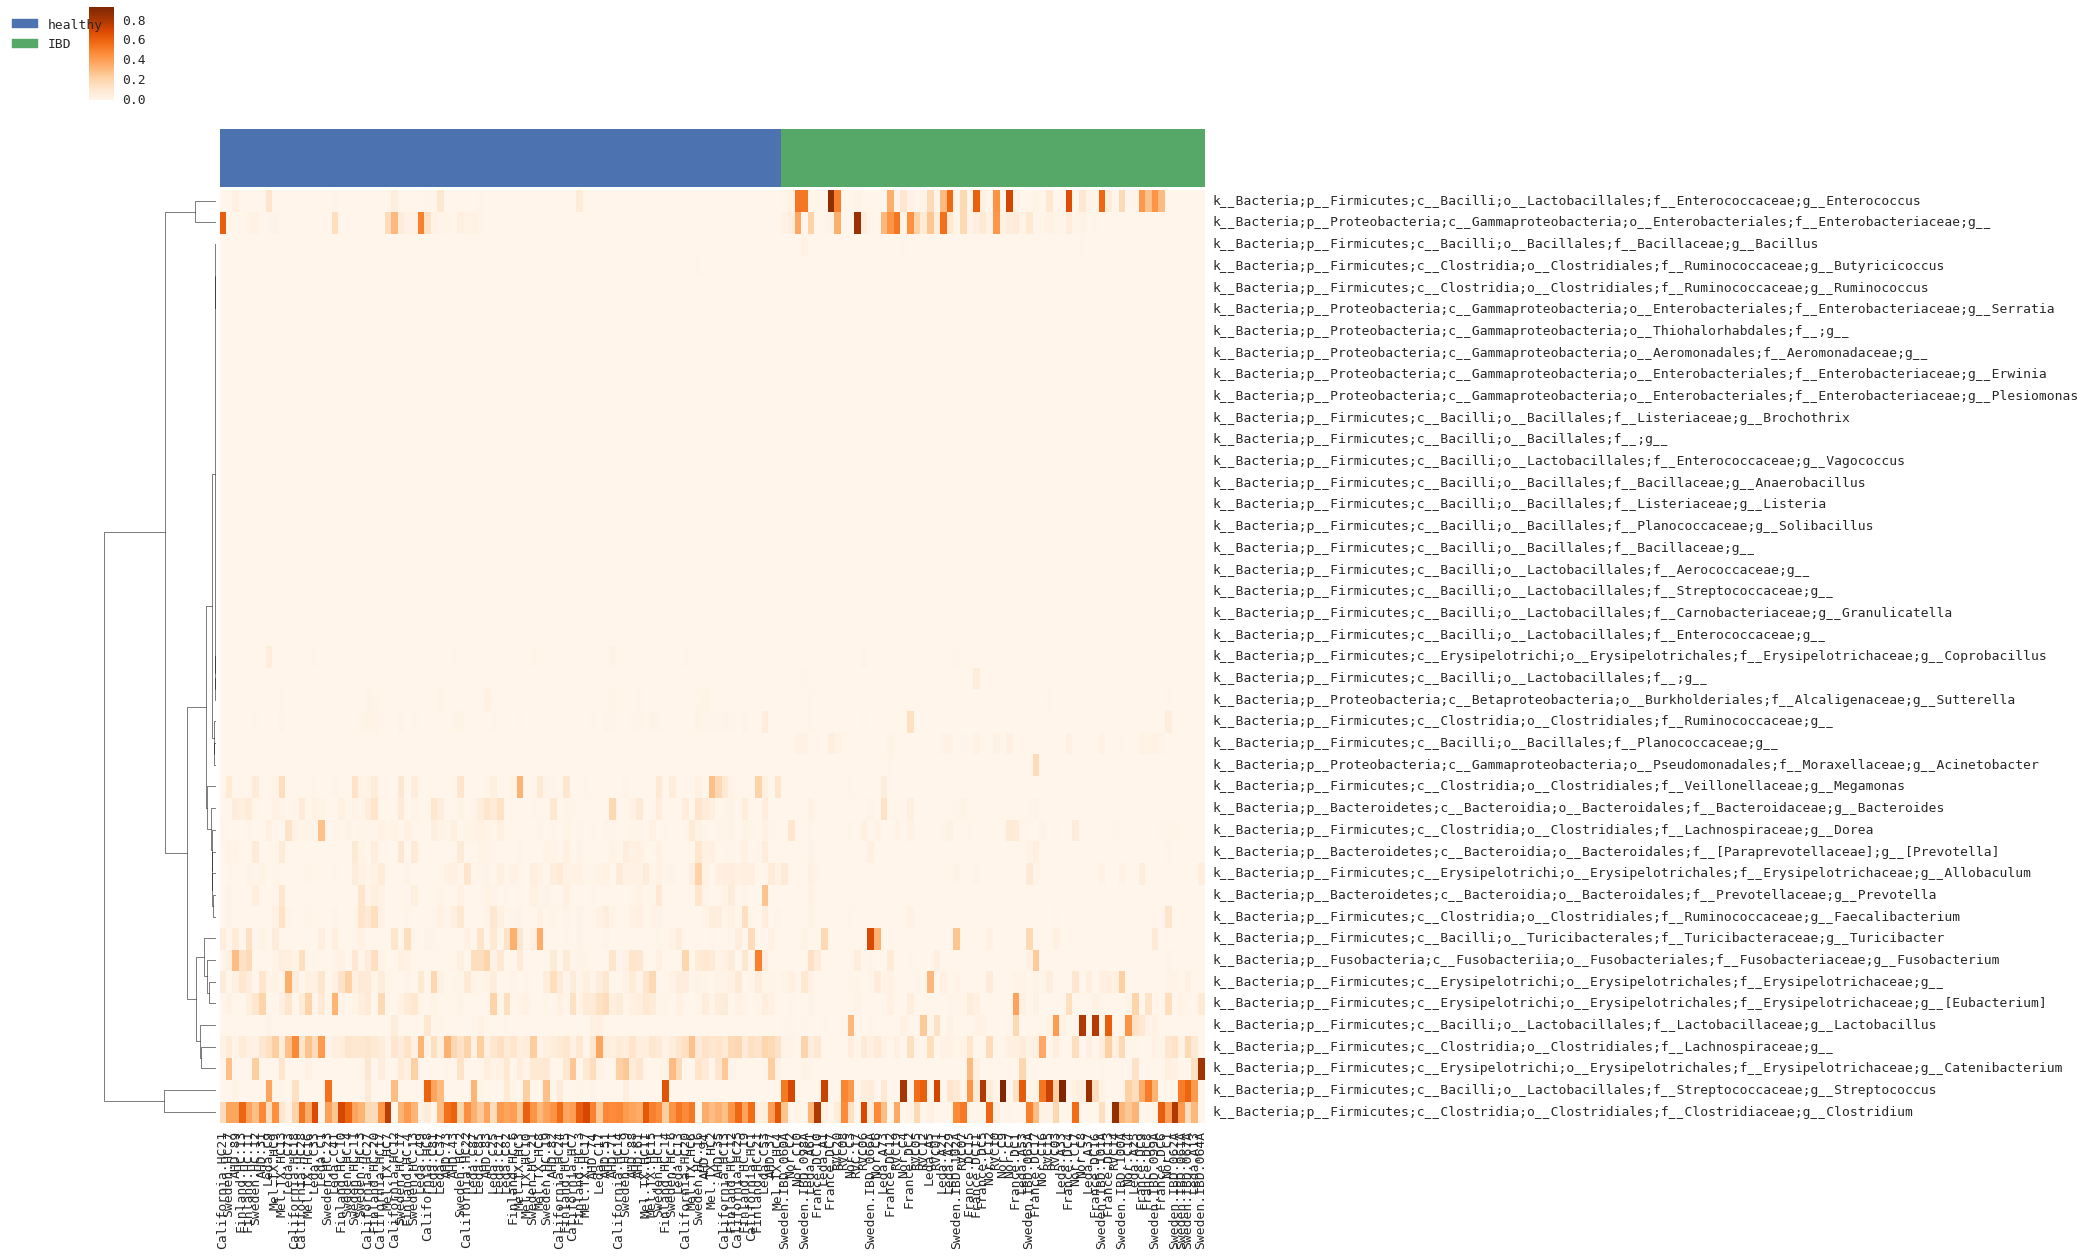

In [4]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

sns.set(font="monospace")
sns.set_context("talk")

bt = load_table('stats/group-significance/no-diarrhea/taxa-summaries-10pct/otu_table.15000.no-diarrhea.10pct_L6.biom')

mf = load_mf('mapping-file-full.alpha.L6index.txt')
mf = mf.loc[bt.ids('sample')]

# dataframe from the group significance table
gsdf = pd.read_csv('stats/group-significance/no-diarrhea/kruskall-wallis-10pct-L6.tsv',
                   sep='\t')
gsdf = gsdf[gsdf['Bonferroni_P'] < 0.05]

current_palette = sns.color_palette()
cat_colors = dict(zip(mf.disease_stat.unique(),
                      current_palette[:3]))

# keep only the significant OTUs
bt.filter(gsdf.OTU.astype(str), axis='observation', inplace=True)
bt.norm()

df = exploding_panda(bt)

sample_order = mf[mf.disease_stat == 'healthy'].index.tolist() + mf[mf.disease_stat != 'healthy'].index.tolist()
df = df[sample_order]

colors = []
for sid in df.columns:
    colors.append(cat_colors[mf.loc[sid].disease_stat])

x = sns.clustermap(df, method="average",
                   row_cluster=True, col_cluster=False,
                   figsize=(20, 20), col_colors=colors,
                   cmap=plt.get_cmap("Oranges"))

handles = []
for key, value in cat_colors.iteritems():
    handles.append(mpatches.Patch(color=value, label=key))

plt.legend(handles=handles)
# x.savefig('clustermap-L6.pdf')

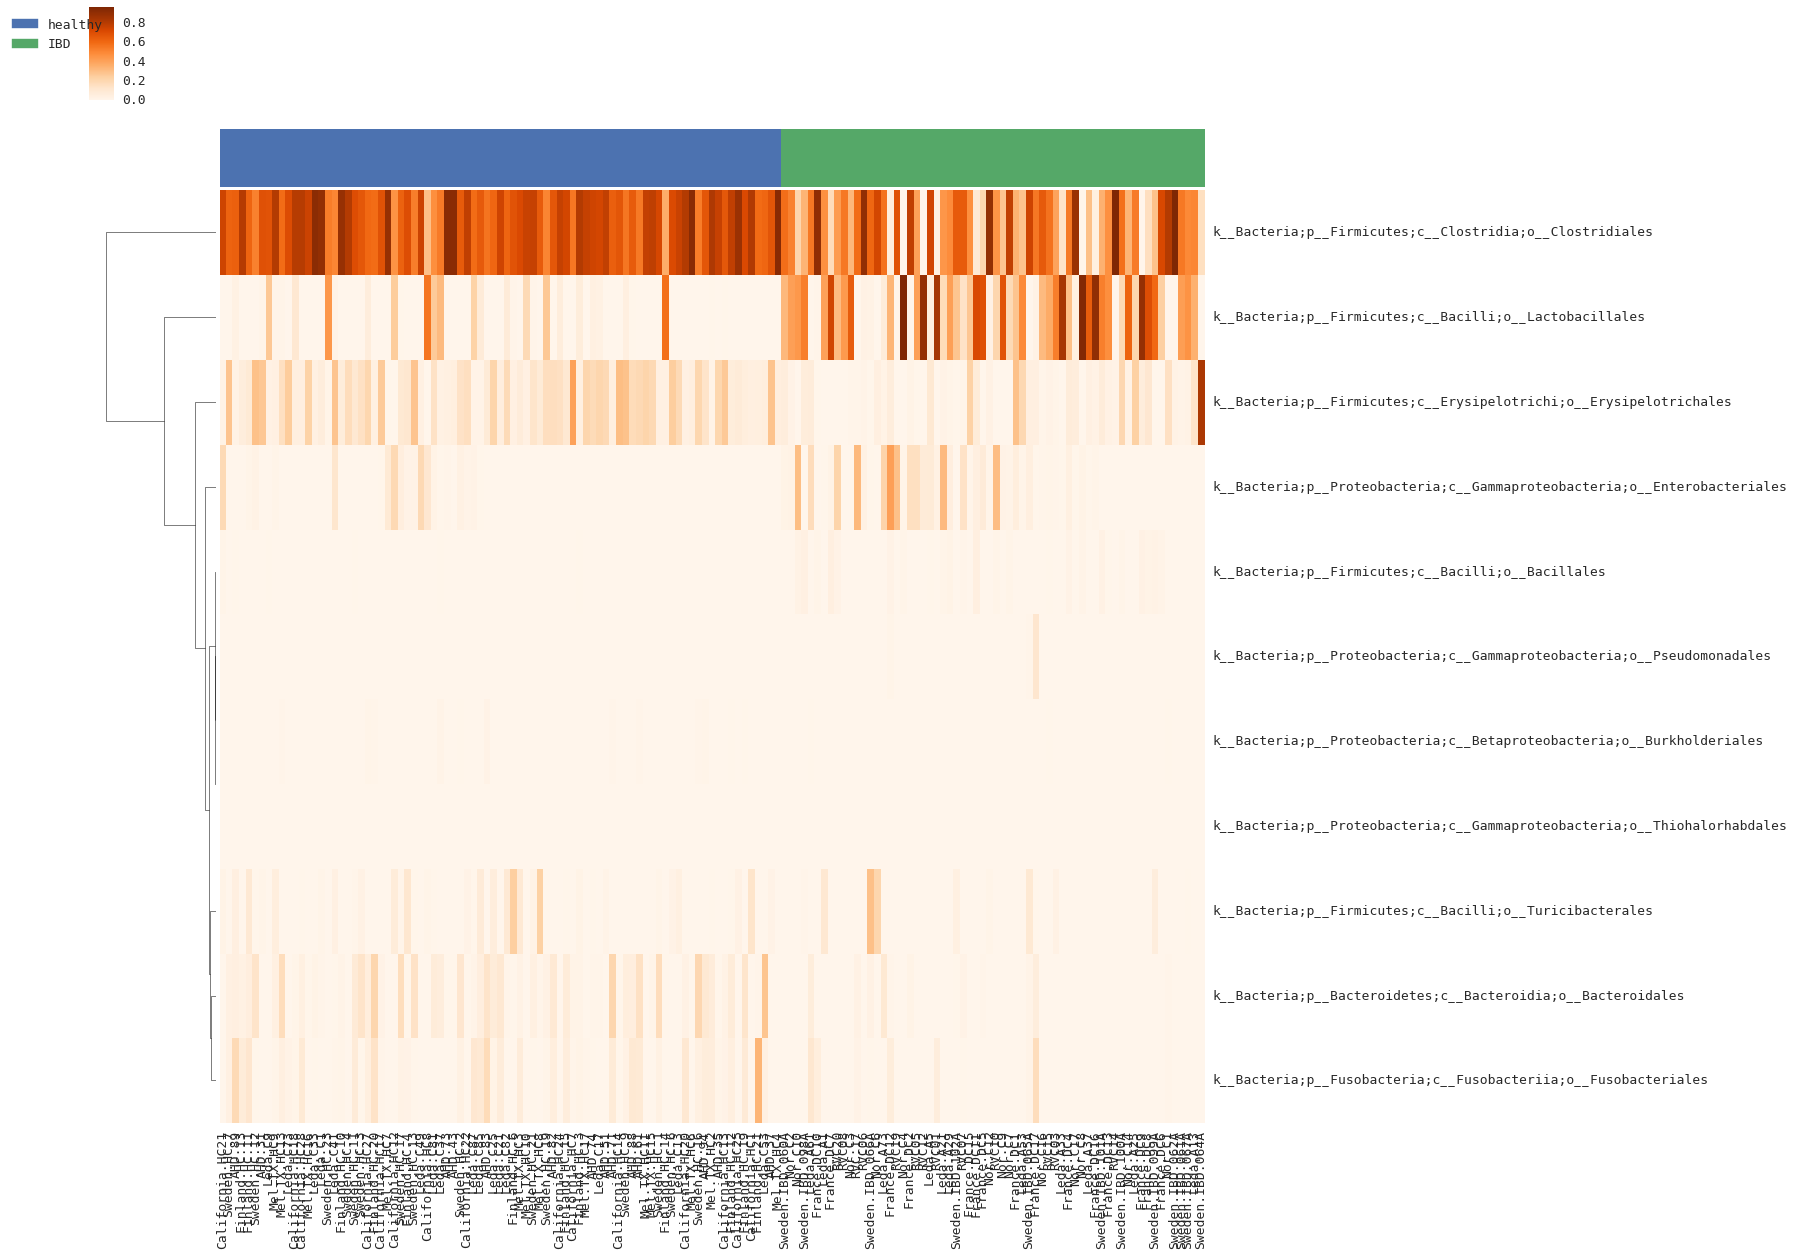

In [5]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

sns.set(font="monospace")
sns.set_context("talk")

bt = load_table('stats/group-significance/no-diarrhea/taxa-summaries-5pct/otu_table.15000.no-diarrhea.5pct_L4.biom')

mf = load_mf('mapping-file-full.alpha.L6index.txt')
mf = mf.loc[bt.ids('sample')]

# dataframe from the group significance table
gsdf = pd.read_csv('stats/group-significance/no-diarrhea/kruskall-wallis-5pct-L4.tsv',
                   sep='\t')
gsdf = gsdf[gsdf['Bonferroni_P'] < 0.05]

current_palette = sns.color_palette()
cat_colors = dict(zip(mf.disease_stat.unique(),
                      current_palette[:3]))

# keep only the significant OTUs
bt.filter(gsdf.OTU.astype(str), axis='observation', inplace=True)
bt.norm()

df = exploding_panda(bt)

sample_order = mf[mf.disease_stat == 'healthy'].index.tolist() + mf[mf.disease_stat != 'healthy'].index.tolist()
df = df[sample_order]

colors = []
for sid in df.columns:
    colors.append(cat_colors[mf.loc[sid].disease_stat])

x = sns.clustermap(df, method="average",
                   row_cluster=True, col_cluster=False,
                   figsize=(20, 20), col_colors=colors,
                   cmap=plt.get_cmap("Oranges"))

handles = []
for key, value in cat_colors.iteritems():
    handles.append(mpatches.Patch(color=value, label=key))

plt.legend(handles=handles)
# x.savefig('clustermap-L6.pdf')